In [2]:
import sys
sys.path.insert(0,'/scratch/aqi5157/pip_packages_and_cache/packages')
print(sys.path)

['/scratch/aqi5157/pip_packages_and_cache/packages', '/scratch/aqi5157/miniconda3/lib/python312.zip', '/scratch/aqi5157/miniconda3/lib/python3.12', '/scratch/aqi5157/miniconda3/lib/python3.12/lib-dynload', '', '/scratch/aqi5157/miniconda3/lib/python3.12/site-packages']


In [9]:
import os
os.environ['TRANSFORMERS_CACHE'] = './cache'

In [10]:
from utils.semanticSimFunctions import getSentenceEmbedding
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import pickle
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
with open('data/all_go_terms_embeddings_dict.pkl', 'rb') as handle:
    all_go_terms_embeddings_dict = pickle.load(handle)
print(len(all_go_terms_embeddings_dict))

11943


/tmp/ipykernel_559781/424616659.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  all_go_terms_embeddings_dict = pickle.load(handle)


In [18]:
!python utils/rank_GOterm_LLM_sim_rand.py --input_file "data/gemma runs/GO_1000_set_processed_merged_corrected.tsv" --emb_file "data/all_go_terms_embeddings_dict.pkl" --topn 3 --output_file "data/gemma runs/simrank_processed_terms.tsv" --llm_model "gemma"

['/scratch/aqi5157/pip_packages_and_cache/packages', '/scratch/aqi5157/LLM_eval_store/utils', '/scratch/aqi5157/miniconda3/lib/python312.zip', '/scratch/aqi5157/miniconda3/lib/python3.12', '/scratch/aqi5157/miniconda3/lib/python3.12/lib-dynload', '/scratch/aqi5157/miniconda3/lib/python3.12/site-packages']
/scratch/aqi5157/pip_packages_and_cache/packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/scratch/aqi5157/LLM_eval_store/utils/rank_GOterm_LLM_sim_rand.py:46: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, y

In [32]:
!conda install matplotlib -y

Channels:
 - defaults
 - bioconda
 - anaconda
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: / 

## Package Plan ##

  environment location: /scratch/aqi5157/miniconda3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cyrus-sasl-2.1.28          |       h52b45da_1         237 KB
    dbus-1.13.18               |       hb2f20db_0         504 KB
    fontconfig-2.14.1          |       h55d465d_3         281 KB
    glib-2.78.4                |       h6a678d5_0         508 KB
    glib-tools-2.78.4          |       h6a678d5_0         115 KB
    gst-plugins-base-1.14.1    |       h6a678d5_1         2.2 MB
    gstreamer-1.14.1           |       h5eee18b_1         1.7 MB
    libclang-14.0.6            |default_hc6dbbc7_2         137 KB
    libclang13-14.0.6          |default_he11475f_2         9.7 MB
    libcups-2.

In [33]:
import matplotlib.pyplot as plt

def process_model_data(file_path, model_name):
    # Read the TSV file
    df = pd.read_csv(file_path, sep="\t")
    
    assigned_name_col = f'{model_name}_assigned_name'
    sim_col = 'LLM_name_GO_term_sim'
    rank_col = 'sim_rank'
    percentile_col = 'true_GO_term_sim_percentile'

    print(f"Summary for {model_name}") 
    # Count occurrences of 'System of unrelated proteins'
    count_unrelated = sum(df[assigned_name_col] == 'System of unrelated proteins')
    print("Occurences of 'Unrelated proteins' : ", count_unrelated)
    
    # Update values for 'System of unrelated proteins'
    df.loc[df[assigned_name_col] == 'System of unrelated proteins', sim_col] = 0
    df.loc[df[assigned_name_col] == 'System of unrelated proteins', rank_col] = 11943
    df.loc[df[assigned_name_col] == 'System of unrelated proteins', percentile_col] = 0
    
    # Count number of zero percentiles
    count_zero_percentile = sum(df[percentile_col] == 0)
    print("Occurences of 'Zero percentiles' : ",count_zero_percentile)
    
    # Sort by percentile and find the median value
    df_sorted = df.sort_values(by=percentile_col, ascending=False)
    median_percentile = df_sorted.iloc[500-1][percentile_col]
    print('half of the sample have the percentile score higher than: ', median_percentile)
    
    # Count number of GO terms in top and bottom 10%
    num_top_10 = sum(1 - df[percentile_col] <= 0.1)
    num_bottom_10 = sum(1 - df[percentile_col] >= 0.9)
    print('number of GO terms in top 10%: ', num_top_10)
    print('number of GO terms in bottom 10%: ', num_bottom_10)
    
    # Count number of GO terms ranked in the top 10
    num_top_10_rank = sum(df[rank_col] <= 10)
    print('number of GO terms ranked top 10: ', num_top_10_rank)

    # Create a histogram for GO terms in each percent bracket
    plt.figure(figsize=(10, 6))
    plt.hist(df[percentile_col], bins=10, edgecolor='black')
    plt.xlabel('Percentile Brackets')
    plt.ylabel('Number of GO Terms')
    plt.title('Distribution of GO Terms across Percentile Brackets')
    plt.show()
    
    return


Summary for gemma
Occurences of 'Unrelated proteins' :  1
Occurences of 'Zero percentiles' :  1
half of the sample have the percentile score higher than:  0.9567947751821152
number of GO terms in top 10%:  618
number of GO terms in bottom 10%:  20
number of GO terms ranked top 10:  88


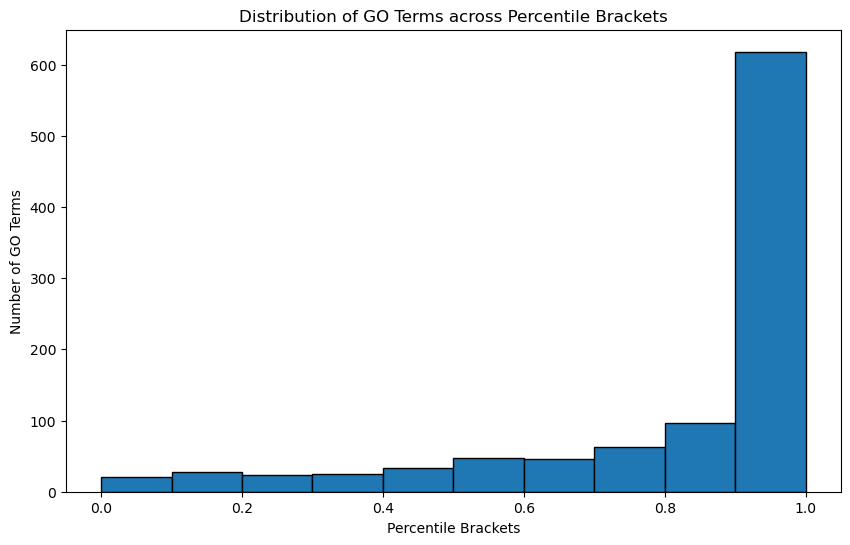

In [34]:
process_model_data("data/gemma runs/simrank_processed_terms.tsv", "gemma")

Summary for llama
Occurences of 'Unrelated proteins' :  88
Occurences of 'Zero percentiles' :  88
half of the sample have the percentile score higher than:  0.9590555136900276
number of GO terms in top 10%:  613
number of GO terms in bottom 10%:  103
number of GO terms ranked top 10:  95


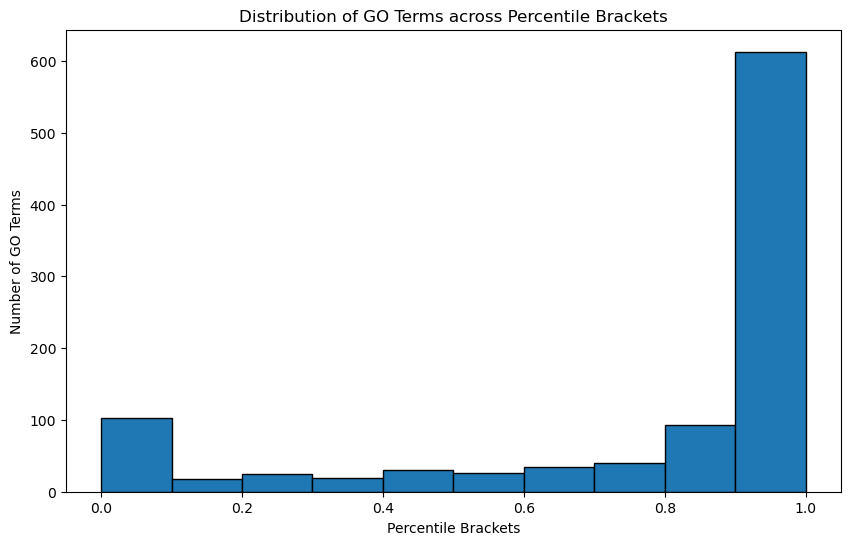

In [35]:
process_model_data("data/llama runs/simrank_processed_terms.tsv", "llama")